# Multi-layer resnet50 from MOSAIKS

## Prepare GeoLife data loader

In [1]:
import os
import sys
import time
import inspect
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
import timm

from sklearn.cluster import KMeans
from sklearn.feature_extraction.image import extract_patches_2d

CURR_DIR = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
PARENT_DIR = os.path.dirname(CURR_DIR)
sys.path.insert(0, "/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/remote_sensing")

from dataset.pytorch_dataset import GeoLifeCLEF2022Dataset
from torch.utils.data import random_split, DataLoader
from mosaiks_utils import visualize_3d_patches, visTensor, normalize_patches

random_state = np.random.RandomState(0)

/home/mila/s/sara.ebrahim-elkafrawy/.conda/envs/ffcv2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = "/network/scratch/s/sara.ebrahim-elkafrawy/small_geo_data"  # "/network/scratch/s/sara.ebrahim-elkafrawy/" 
split = "train"
use_ffcv_loader = False
num_species= 17037
bands = ["rgb"] 
batch_size = 1
num_workers = 0

In [3]:
geo_train_dataset = GeoLifeCLEF2022Dataset(
                root=data_dir,
                subset=split,
                use_ffcv_loader=use_ffcv_loader,
                region="both",
                patch_data=bands,
                use_rasters=False,
                patch_extractor=None,
                transform=None,
                target_transform=None,
                opts=None,
            )

geo_train_loader = DataLoader(
                geo_train_dataset,
                batch_size=batch_size,
                num_workers=num_workers,
                shuffle=True,
                pin_memory=True,
            )

trf = torch.nn.Sequential(
    transforms.Resize(size=(224, 224), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.Normalize((106.9413, 114.8733, 104.5285), (51.0005, 44.8595, 43.2014)),
)

## Define the network

In [4]:
# hyperparameters for the model
mode = 'whiten' # options ['whiten', 'no_whiten']
whiten = True
zca_bias = 0.001
save_path = f"/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/ckpts/resnet50_mosaiks_{mode}.pt"
max_iter = 6
eps = 1e-4
random_state = np.random.RandomState(0)

### slicing up resnet50
Manually set the indices of all convolution layers and the afterwards activation layers

In [5]:
model    = timm.create_model(model_name = 'resnet50', pretrained = True)
model.fc = nn.Linear(2048, num_species)

In [6]:
model_path = "/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/ckpts/resnet50_mosaiks_whiten.pt"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [7]:
# set the weights for hte first layer
# list(model.named_parameters())[0][1].data = torch.from_numpy(kmeans.cluster_centers_.reshape(64, 3, 7, 7))

## extract all conv layers

In [8]:
# for name, param in model.named_parameters():
#     print(name, param.shape)

In [9]:
conv_lyrs = []
idx = 0
for name, param in model.named_parameters():
    if 'conv' in name:
        conv_lyrs.append(idx)
    idx += 1

In [10]:
# conv_lyrs

In [11]:
# for l in conv_lyrs:
#     print(list(model.named_parameters())[l][1].data.shape)

### Hook the activation layers

In [12]:
features_dim = {}
def get_features(name):
    def hook(model, input, output):
        features_dim[name] = output.detach()
    return hook

In [13]:
model.act1.register_forward_hook(get_features('conv_layer_0'))  #model.layer1[1].act2

model.layer1[0].act1.register_forward_hook(get_features('conv_layer_3'))
model.layer1[0].act2.register_forward_hook(get_features('conv_layer_6'))
model.layer1[0].act3.register_forward_hook(get_features('conv_layer_9'))

model.layer1[1].act1.register_forward_hook(get_features('conv_layer_15'))
model.layer1[1].act2.register_forward_hook(get_features('conv_layer_18'))
model.layer1[1].act3.register_forward_hook(get_features('conv_layer_21'))

model.layer1[2].act1.register_forward_hook(get_features('conv_layer_24'))
model.layer1[2].act2.register_forward_hook(get_features('conv_layer_27'))
model.layer1[2].act3.register_forward_hook(get_features('conv_layer_30'))

model.layer2[0].act1.register_forward_hook(get_features('conv_layer_33'))
model.layer2[0].act2.register_forward_hook(get_features('conv_layer_36'))
model.layer2[0].act3.register_forward_hook(get_features('conv_layer_39'))

model.layer2[1].act1.register_forward_hook(get_features('conv_layer_45'))
model.layer2[1].act2.register_forward_hook(get_features('conv_layer_48'))
model.layer2[1].act3.register_forward_hook(get_features('conv_layer_51'))

model.layer2[2].act1.register_forward_hook(get_features('conv_layer_54'))
model.layer2[2].act2.register_forward_hook(get_features('conv_layer_57'))
model.layer2[2].act3.register_forward_hook(get_features('conv_layer_60'))

model.layer2[3].act1.register_forward_hook(get_features('conv_layer_63'))
model.layer2[3].act2.register_forward_hook(get_features('conv_layer_66'))
model.layer2[3].act3.register_forward_hook(get_features('conv_layer_69'))

model.layer3[0].act1.register_forward_hook(get_features('conv_layer_72'))
model.layer3[0].act2.register_forward_hook(get_features('conv_layer_75'))
model.layer3[0].act3.register_forward_hook(get_features('conv_layer_78'))

model.layer3[1].act1.register_forward_hook(get_features('conv_layer_84'))
model.layer3[1].act2.register_forward_hook(get_features('conv_layer_87'))
model.layer3[1].act3.register_forward_hook(get_features('conv_layer_90'))
    
model.layer3[2].act1.register_forward_hook(get_features('conv_layer_93'))
model.layer3[2].act2.register_forward_hook(get_features('conv_layer_96'))
model.layer3[2].act3.register_forward_hook(get_features('conv_layer_99'))
    
model.layer3[3].act1.register_forward_hook(get_features('conv_layer_102'))
model.layer3[3].act2.register_forward_hook(get_features('conv_layer_105'))
model.layer3[3].act3.register_forward_hook(get_features('conv_layer_108'))

model.layer3[4].act1.register_forward_hook(get_features('conv_layer_111'))
model.layer3[4].act2.register_forward_hook(get_features('conv_layer_114'))
model.layer3[4].act3.register_forward_hook(get_features('conv_layer_117'))

model.layer3[5].act1.register_forward_hook(get_features('conv_layer_120'))
model.layer3[5].act2.register_forward_hook(get_features('conv_layer_123'))
model.layer3[5].act3.register_forward_hook(get_features('conv_layer_126'))    

model.layer4[0].act1.register_forward_hook(get_features('conv_layer_129'))
model.layer4[0].act2.register_forward_hook(get_features('conv_layer_132'))
model.layer4[0].act3.register_forward_hook(get_features('conv_layer_135'))    

model.layer4[1].act1.register_forward_hook(get_features('conv_layer_141'))
model.layer4[1].act2.register_forward_hook(get_features('conv_layer_144'))
model.layer4[1].act3.register_forward_hook(get_features('conv_layer_147'))    

model.layer4[2].act1.register_forward_hook(get_features('conv_layer_150'))
model.layer4[2].act2.register_forward_hook(get_features('conv_layer_153'))
model.layer4[2].act3.register_forward_hook(get_features('conv_layer_156'))    

In [14]:
def get_featuremap_patches(train_dataloader, layer_idx, patch_size, max_patches, random_state):
    '''expects image shape of (width, height, n_channels)
    
    Parameters
    ----------
    train_dataloader: Dataset
                   dataloader for the training dataset to extract from
    
    layer_idx: int
               The index of the current feature map. 
               conv_lyrs[layer_idx] should return the real index of the current weights/parameter 
               
    patch_size: (int, int)
                Receptive field size or width and height of the extracted patch.
                
    max_patches: int
                 The number of extracted patches.
    
    random_state: int
                  Random state for reproducibility 
    Return
    ------
    patches: ndarrah
             final patches of size (max_patches, patch_size, n_channels)
    '''
    all_patches = []
    
    for batch in train_dataloader:
        
        patches, target, meta = batch
        patches['rgb'] = trf(patches['rgb'])
        
        if layer_idx == 0:
            curr_feats = patches['rgb'].numpy()
        else:
            _ = model(patches['rgb'])
            curr_feats = features_dim[f'conv_layer_{conv_lyrs[layer_idx-1]}'].numpy() 

        curr_feats = curr_feats.squeeze(0)
        curr_feats = curr_feats.transpose((1,2,0))

        # curr_feat_map: expected shape: (width, height, n_channels)
        # output shape: (max_patches, patch_size, n_channels)
        random_patches = extract_patches_2d(curr_feats, 
                                  patch_size, 
                                  max_patches=max_patches,
                                  random_state=random_state)
        random_patches = np.reshape(random_patches, (len(random_patches), -1))

        all_patches.append(random_patches)
    
    return np.concatenate(all_patches, axis=0)

In [15]:
for layer_idx, conv_idx in enumerate(conv_lyrs):

    if conv_idx < 150:
        continue
        
    if layer_idx == len(conv_lyrs):
        break
    print(f'for conv layer idx#{conv_idx}')
    
    curr_param_sz = list(model.named_parameters())[conv_idx][1].data.shape
    num_clusters = curr_param_sz[0]
    num_ch = curr_param_sz[1]
    patch_size = (curr_param_sz[2], curr_param_sz[3])
    num_iters = max_iter   # The online learning part: cycle over the whole dataset 6 times
    print(f'number of clusters:{num_clusters}, num_ch:{num_ch}, patch_size:{patch_size}')
    print(f'curr_param_sz:{curr_param_sz}')
    
    if layer_idx == 0:
        max_patches = num_clusters
        print(f'extract random patches from the images pixels')
    else: 
        max_patches = int(num_clusters/4)
        print(f'extract random patches from activation output after conv_layer_#{conv_lyrs[layer_idx-1]}')
        
    print(f'number of random patches from each image: {max_patches}')


    # Step#1: extract random patches  shape:(32064, 147)
    featmap_patches = get_featuremap_patches(geo_train_loader,
                                             layer_idx=layer_idx,
                                             patch_size=patch_size,
                                             max_patches=max_patches,
                                             random_state=random_state)
    print(f'num of total patches: {len(featmap_patches)}')
    
    # Step#2: normalize and whiten the patches
    print(f'Start normalizing [and] whitening ...')
    whiten_patches, means, zca_mat = normalize_patches(featmap_patches, zca_bias=zca_bias, whiten=whiten)
    print(f'whiten_patches stats [min],[max],[mean],[std]: {whiten_patches.min():.3f}, {whiten_patches.max():.3f}, {whiten_patches.mean():.3f}, {whiten_patches.std():.3f}')

    # Step#3: apply kmeans to the whitened patches
    print(f'Running KMeans ...')
    kmeans = KMeans(n_clusters=num_clusters, 
                    random_state=random_state,
                    max_iter=max_iter,
                    verbose=False)
    kmeans_geo = kmeans.fit(whiten_patches)
    print(f'Finished KMeans fit')
    
    # change the weights of the corresponding conv layer
    print(f'Updating parameter idx#{conv_idx} with size: {curr_param_sz}')    
    list(model.named_parameters())[conv_idx][1].data = torch.from_numpy(
        kmeans_geo.cluster_centers_.reshape(
                                            num_clusters, 
                                            patch_size[0], 
                                            patch_size[1],
                                            num_ch,).transpose(0, 3, 1, 2)
                                        )
#     norm_param = (x - x.mean())/(x.std())
#     model[curr_param_idx].weight.data = norm_param
    
    # save the model
    torch.save(model.state_dict(), save_path)
    print(f'Model saved at {save_path}')

for conv layer idx#150
number of clusters:512, num_ch:2048, patch_size:(1, 1)
curr_param_sz:torch.Size([512, 2048, 1, 1])
extract random patches from activation output after conv_layer_#147
number of random patches from each image: 128
num of total patches: 98196
Start normalizing [and] whitening ...
zca bias 0.001
negatives eigen values: (0,)


/network/scratch/s/sara.ebrahim-elkafrawy/ecosystem_project/remote_sensing/notebooks/mosaiks/mosaiks_utils.py:109: ComplexWarning: Casting complex values to real discards the imaginary part
  return patches_normalized.reshape(orig_shape).astype("float32"), means, global_ZCA


whiten_patches stats [min],[max],[mean],[std]: -5.389, 26.563, 0.000, 0.370
Running KMeans ...
Finished KMeans fit
Updating parameter idx#150 with size: torch.Size([512, 2048, 1, 1])
Model saved at /home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/ckpts/resnet50_mosaiks_whiten.pt
for conv layer idx#153
number of clusters:512, num_ch:512, patch_size:(3, 3)
curr_param_sz:torch.Size([512, 512, 3, 3])
extract random patches from activation output after conv_layer_#150
number of random patches from each image: 128
num of total patches: 50100
Start normalizing [and] whitening ...
zca bias 0.001
negatives eigen values: (0,)
whiten_patches stats [min],[max],[mean],[std]: -3.445, 14.360, 0.000, 0.276
Running KMeans ...
Finished KMeans fit
Updating parameter idx#153 with size: torch.Size([512, 512, 3, 3])
Model saved at /home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/ckpts/resnet50_mosaiks_whiten.pt
for conv layer idx#156
number of clusters:2048, num_ch:512, patch_size:

## Visualize the filters for the first layer

In [22]:
def check_weights(weights_data):
    print(f'min: {weights_data.min()}')
    print(f'max: {weights_data.max()}')
    print(f'mean: {weights_data.mean()}')
    print(f'std: {weights_data.std()}')
    print(f'num_complex numbers: {np.iscomplex(weights_data.numpy()).sum()}')
check_weights(list(model.named_parameters())[0][1].data)

min: -1.528911828994751
max: 1.6349693536758423
mean: 9.731370376186987e-09
std: 0.2368534505367279
num_complex numbers: 0


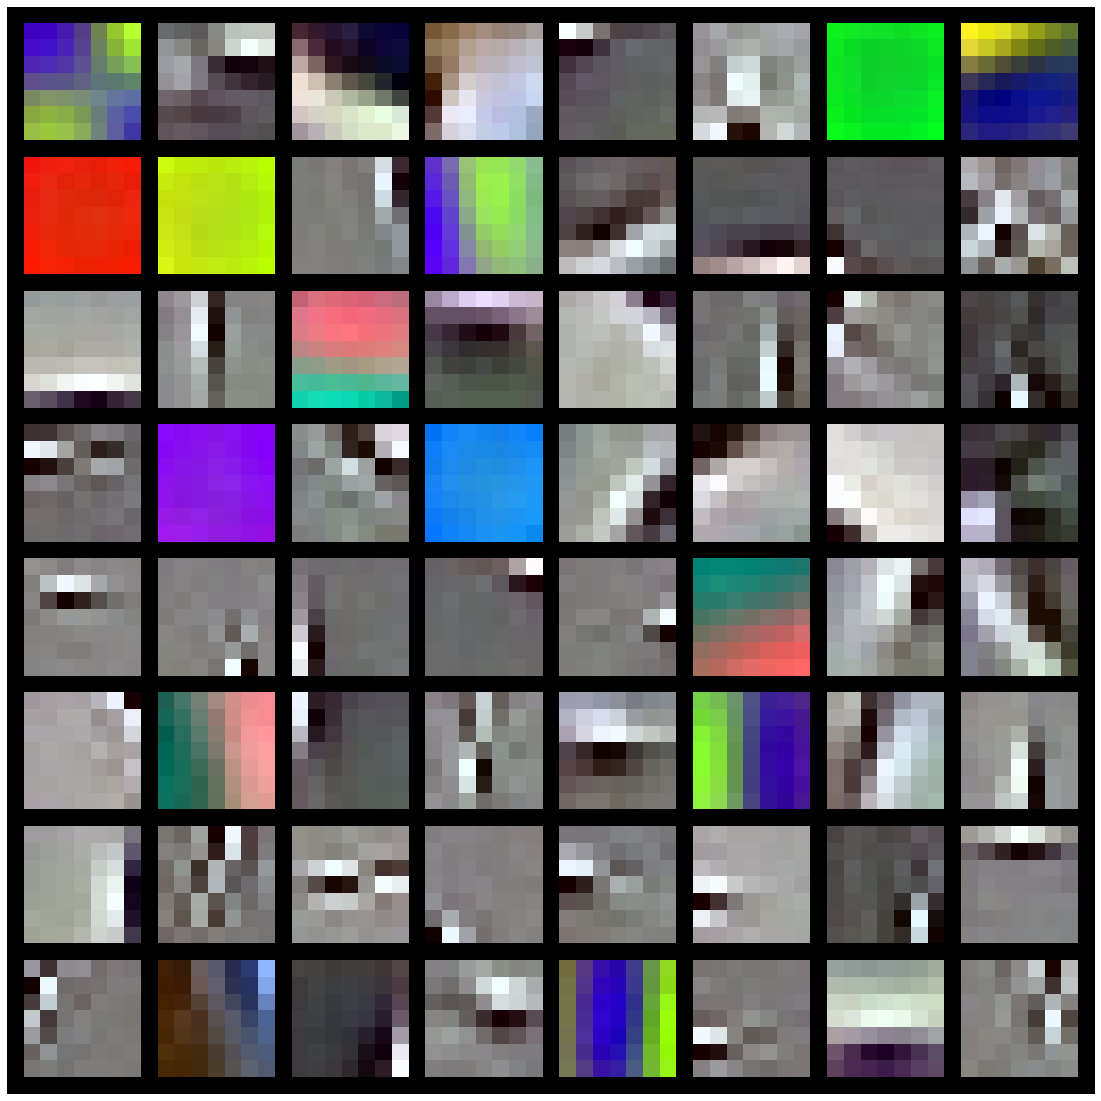

In [23]:
visTensor(list(model.named_parameters())[0][1].data, ch=0, allkernels=False)
plt.axis('off')
plt.ioff()
plt.rcParams['savefig.facecolor']='white'
plt.savefig(f'conv1_resnet50_{mode}_color.png')
plt.show()

## Debug the shapes

In [18]:
# model_path = "/home/mila/s/sara.ebrahim-elkafrawy/scratch/ecosystem_project/ckpts/mosaiks_resnet50_no_whiten_minibatch.pt"
# model.load_state_dict(torch.load(model_path))

In [19]:
# def check_weights(weights_data):
#     print(f'min: {weights_data.min()}')
#     print(f'max: {weights_data.max()}')
#     print(f'mean: {weights_data.mean()}')
#     print(f'std: {weights_data.std()}')
#     print(f'num_complex numbers: {np.iscomplex(weights_data.numpy()).sum()}')

In [20]:
# check_weights(list(model.named_parameters())[0][1].data)

In [21]:
# for layer_idx, conv_idx in enumerate(conv_lyrs):

#     if layer_idx == len(conv_lyrs):
#         break
        
#     print(f'for conv layer idx#{conv_idx}')
    
#     curr_param_sz = list(model.named_parameters())[conv_idx][1].data.shape
    
#     num_feats = curr_param_sz[0]
#     num_ch = curr_param_sz[1]
#     patch_size = (curr_param_sz[2], curr_param_sz[3])
#     num_iters = max_iter   # The online learning part: cycle over the whole dataset 6 times
#     max_patches = int(num_feats/4)

#     print(f'num_feats:{num_feats}, num_ch:{num_ch}, patch_size:{patch_size}')
#     print(f'curr_param_sz:{curr_param_sz}')

#     geo_train_loader = DataLoader(
#                     geo_train_dataset,
#                     batch_size=batch_size,
#                     num_workers=num_workers,
#                     shuffle=True,
#                     pin_memory=True,
#                 )

#     index = 0
#     buffer = []

#     patches, target, meta = next(iter(geo_train_loader))

#     # this is trf_stand: means standardization with the GeoLife stats
#     patches['rgb'] = trf(patches['rgb'])
#     _ = model(patches['rgb'])

#     if layer_idx == 0:
#         curr_feats = patches['rgb'].numpy()
#     else:
#         print(f'activation output after conv_layer_#{conv_lyrs[layer_idx-1]}')
#         curr_feats = features_dim[f'conv_layer_{conv_lyrs[layer_idx-1]}'].numpy()  



#     print(f'curr_feats: {curr_feats.shape}')
#     curr_feats = curr_feats.squeeze(0)
#     curr_feats = curr_feats.transpose((1,2,0))

#     # expects image shape of (width, height, n_channels)
#     data = extract_patches_2d(curr_feats, 
#                               patch_size, 
#                               max_patches=max_patches,
#                               random_state=random_state)
#     data = np.reshape(data, (len(data), -1))
#     buffer.append(data)
#     index += 1

#     tmp = np.random.random((num_feats, num_ch*patch_size[0]*patch_size[1]))

#     # change the weights of the corresponding conv layer
#     print(f'Updating parameter idx#{conv_idx} with size: {curr_param_sz}')
#     tmp_tensor = torch.from_numpy(tmp.reshape(
#                                         num_feats, 
#                                         patch_size[0], 
#                                         patch_size[1],
#                                         num_ch,).transpose(0, 3, 1, 2))
#     tmp_tensor = tmp_tensor.type(torch.FloatTensor)
#     list(model.named_parameters())[conv_idx][1].data =  tmp_tensor


